
## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [10]:
# Load pickled data
import pickle

training_file = "../traffic-signs-data/train.p"
validation_file= "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train, X_train_size, X_train_coords = train['features'], train['labels'], train["sizes"], train["coords"]
X_valid, y_valid, X_valid_size, X_valid_coords = valid['features'], valid['labels'], valid["sizes"], valid["coords"]
X_test, y_test, X_test_size, X_test_coords = test['features'], test['labels'], test["sizes"], test["coords"]

## Step 1: Basic Summary of the Data Set 

In [11]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = np.unique(np.concatenate([y_train, y_valid, y_test])).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### visualization of the dataset

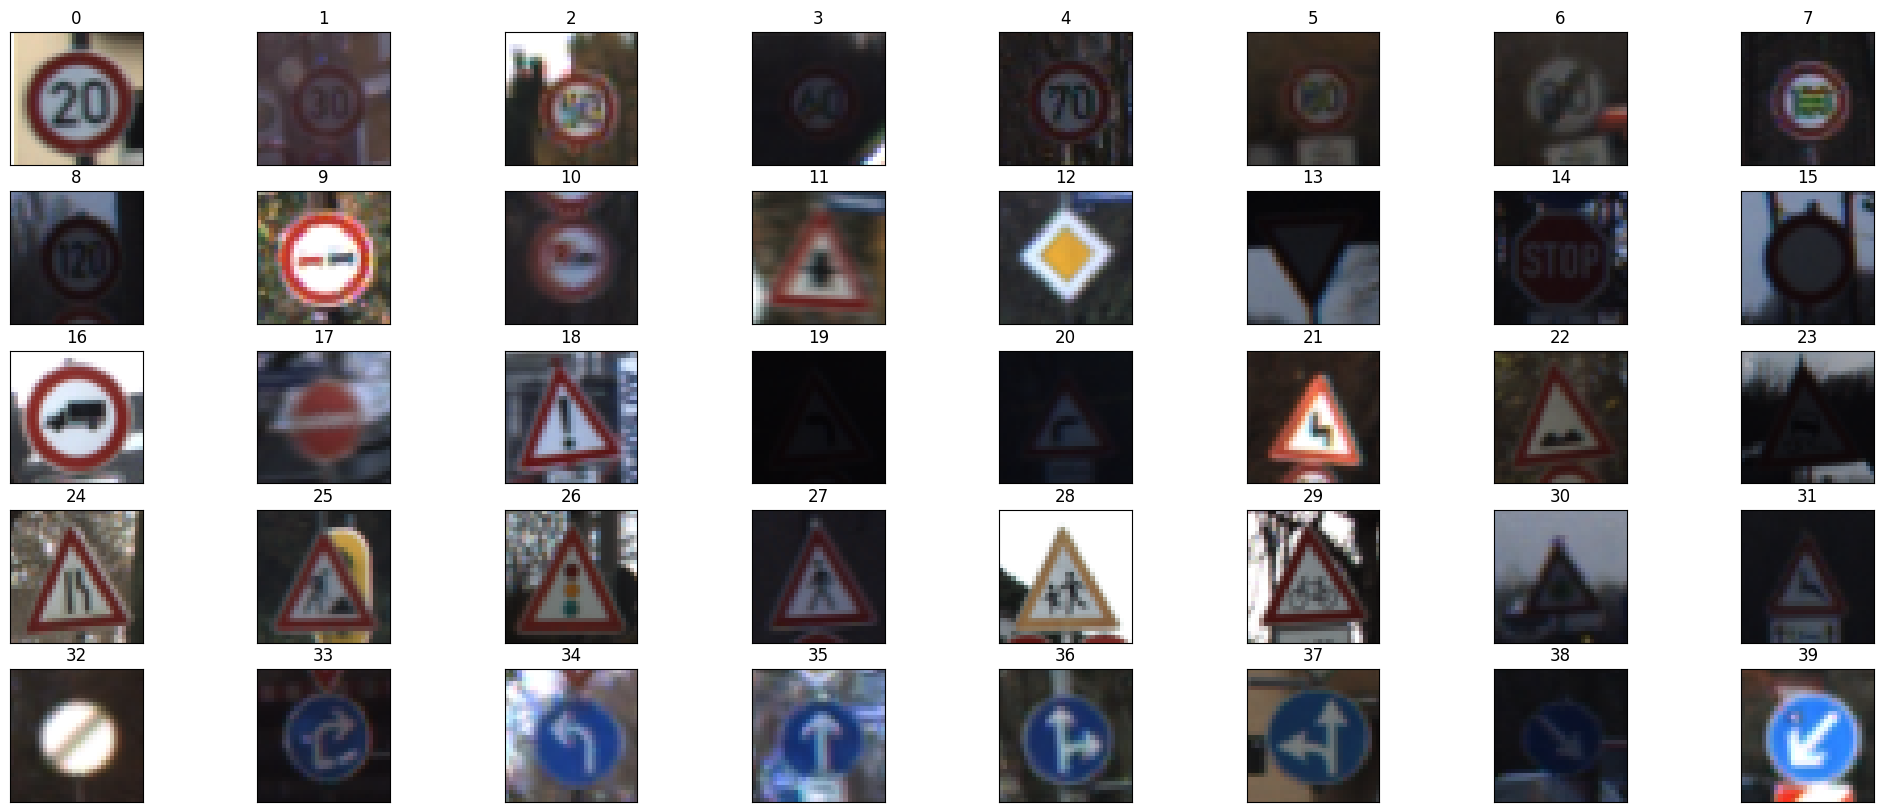

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax_array = plt.subplots(5, 8, figsize=(25, 10))
for i, ax in enumerate(ax_array.flatten()):
    class_id = i
    X_train_in_class = X_train[y_train==class_id]
    ax.imshow(X_train_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
fig.savefig("./docs/traffic_signs.jpg", dpi=fig.dpi)
plt.show()

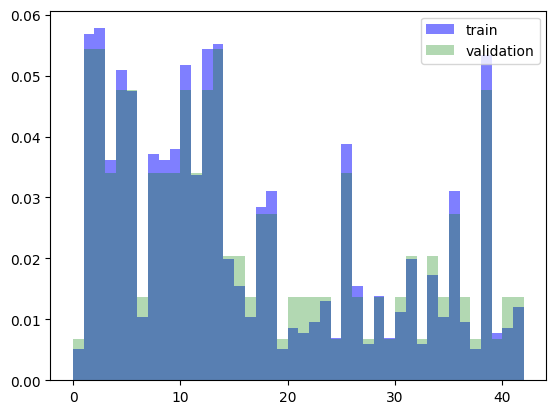

In [13]:
import matplotlib.pyplot as plt

weights_train = np.ones(len(y_train)) / len(y_train)
weights_valid = np.ones(len(y_valid)) / len(y_valid)
bins = range(43)
plt.hist(y_train, bins=bins, weights=weights_train, alpha=0.5, label="train", color="blue")
plt.hist(y_valid, bins=bins, weights=weights_valid, alpha=0.3, label="validation", color="green")
plt.legend(loc='upper right')
plt.savefig("./docs/traffic_signs_classes.jpg")
plt.show()

## Step 2: Design Model

### Preprocess the Data Set 

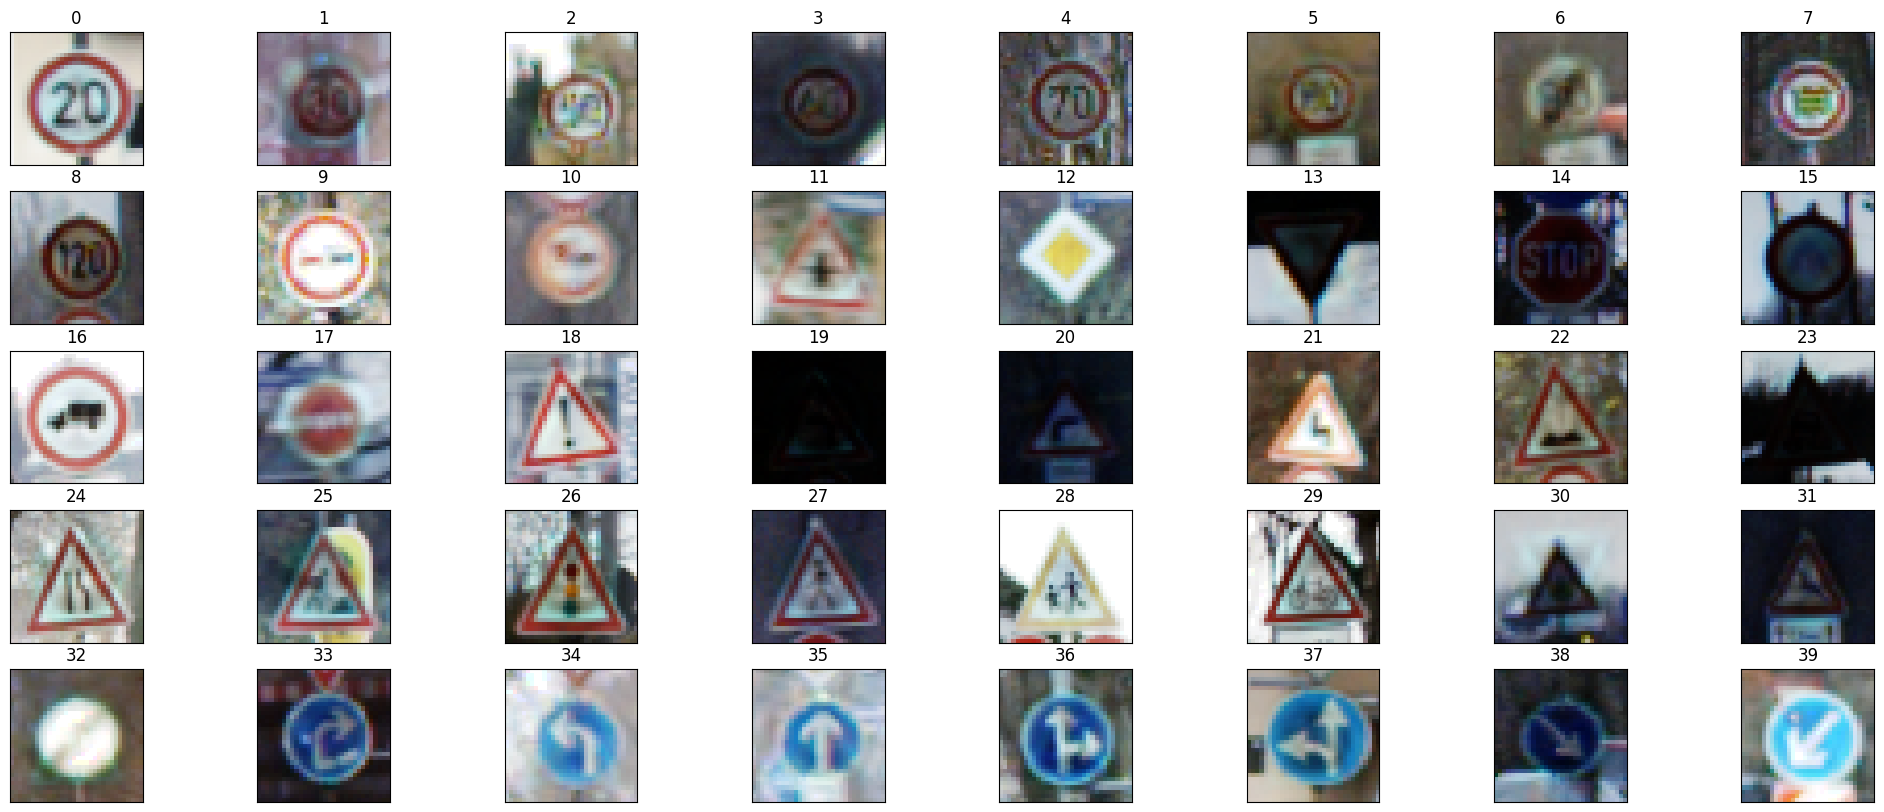

In [62]:
from skimage import exposure, io
from skimage import color

def preprocess(img, clip_limit=0.2):
    img= exposure.equalize_adapthist(img, clip_limit=clip_limit)
    # channel_list = []
    # for channel in range(3):
    #     channel_list.append(img[:,:,channel]/img[:,:,channel].max())
    # img_scaled = np.dstack(channel_list)
    img_scaled = img / img.max()
    # img_scaled = (img-np.mean(img))/np.std(img)
    return img_scaled

# img_norm = preprocess(X_train[1000])
# io.imshow(img_norm)

X_train_norm = np.apply_along_axis(preprocess, 0, X_train)
X_valid_norm = np.apply_along_axis(preprocess, 0, X_valid)
X_test_norm = np.apply_along_axis(preprocess, 0, X_test)


fig, ax_array = plt.subplots(5, 8, figsize=(25, 10))
for i, ax in enumerate(ax_array.flatten()):
    class_id = i
    X_train_in_class = X_train_norm[y_train==class_id]
    ax.imshow(X_train_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
fig.savefig("./docs/traffic_sign_preprocessed.jpg", dpi=fig.dpi)
plt.show()


### Model Architecture

In [15]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def Model(x, keep_prob):    
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Conv Output = 32x32x64. Pooling Output = 16x16x64
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 64), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(64))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)

    # Layer 2: Convolutional. Conv Output = 16x16x128. Pooling Output = 8x8x128. Flatten Output = 8192
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(128))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)
    fc0   = tf.layers.flatten(conv2)

    # Layer 3: Fully Connected. Input = 8192. Output = 128.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(8192, 128), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(128))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # Layer 5: Fully Connected. Input = 128. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    
    return logits

2023-11-13 21:53:00.310731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 21:53:00.310765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 21:53:00.310786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 21:53:00.315705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


### Training

In [22]:
EPOCHS = 50
BATCH_SIZE = 256
BATCH_PER_EPOCH = 500

#define graph
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

#train
rate = 0.001
logits = Model(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_steps = optimizer.minimize(loss)

#evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

/tmp/ipykernel_222611/3719227535.py:23: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  fc0   = tf.layers.flatten(conv2)


In [23]:
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

#data augmentation
img_gen = ImageDataGenerator(rotation_range=9.,
                                   zoom_range=0.3,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train_epoch, y_train_epoch = shuffle(X_train_norm, y_train)
        batch = 0
        # for batch_x, batch_y in img_gen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_epoch[offset:end], y_train_epoch[offset:end]
            sess.run(training_steps, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            # batch += 1
            # if batch > BATCH_PER_EPOCH:
            #     break
            
        train_accuracy = evaluate(X_train_norm, y_train)
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './models/Model')
    print("Model saved")

2023-11-13 22:01:56.730939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9625 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-13 22:01:56.731450: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9610 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Training...


2023-11-13 22:01:59.390351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


EPOCH 1 ...
Train Accuracy = 0.091
Validation Accuracy = 0.094

EPOCH 2 ...
Train Accuracy = 0.248
Validation Accuracy = 0.214

EPOCH 3 ...
Train Accuracy = 0.446
Validation Accuracy = 0.392

EPOCH 4 ...
Train Accuracy = 0.610
Validation Accuracy = 0.530

EPOCH 5 ...
Train Accuracy = 0.752
Validation Accuracy = 0.647

EPOCH 6 ...
Train Accuracy = 0.845
Validation Accuracy = 0.732

EPOCH 7 ...
Train Accuracy = 0.904
Validation Accuracy = 0.795

EPOCH 8 ...
Train Accuracy = 0.933
Validation Accuracy = 0.816

EPOCH 9 ...
Train Accuracy = 0.952
Validation Accuracy = 0.846

EPOCH 10 ...
Train Accuracy = 0.957
Validation Accuracy = 0.859

EPOCH 11 ...
Train Accuracy = 0.970
Validation Accuracy = 0.867

EPOCH 12 ...
Train Accuracy = 0.980
Validation Accuracy = 0.885

EPOCH 13 ...
Train Accuracy = 0.986
Validation Accuracy = 0.896

EPOCH 14 ...
Train Accuracy = 0.988
Validation Accuracy = 0.900

EPOCH 15 ...
Train Accuracy = 0.991
Validation Accuracy = 0.900

EPOCH 16 ...
Train Accuracy = 0.99

### Test

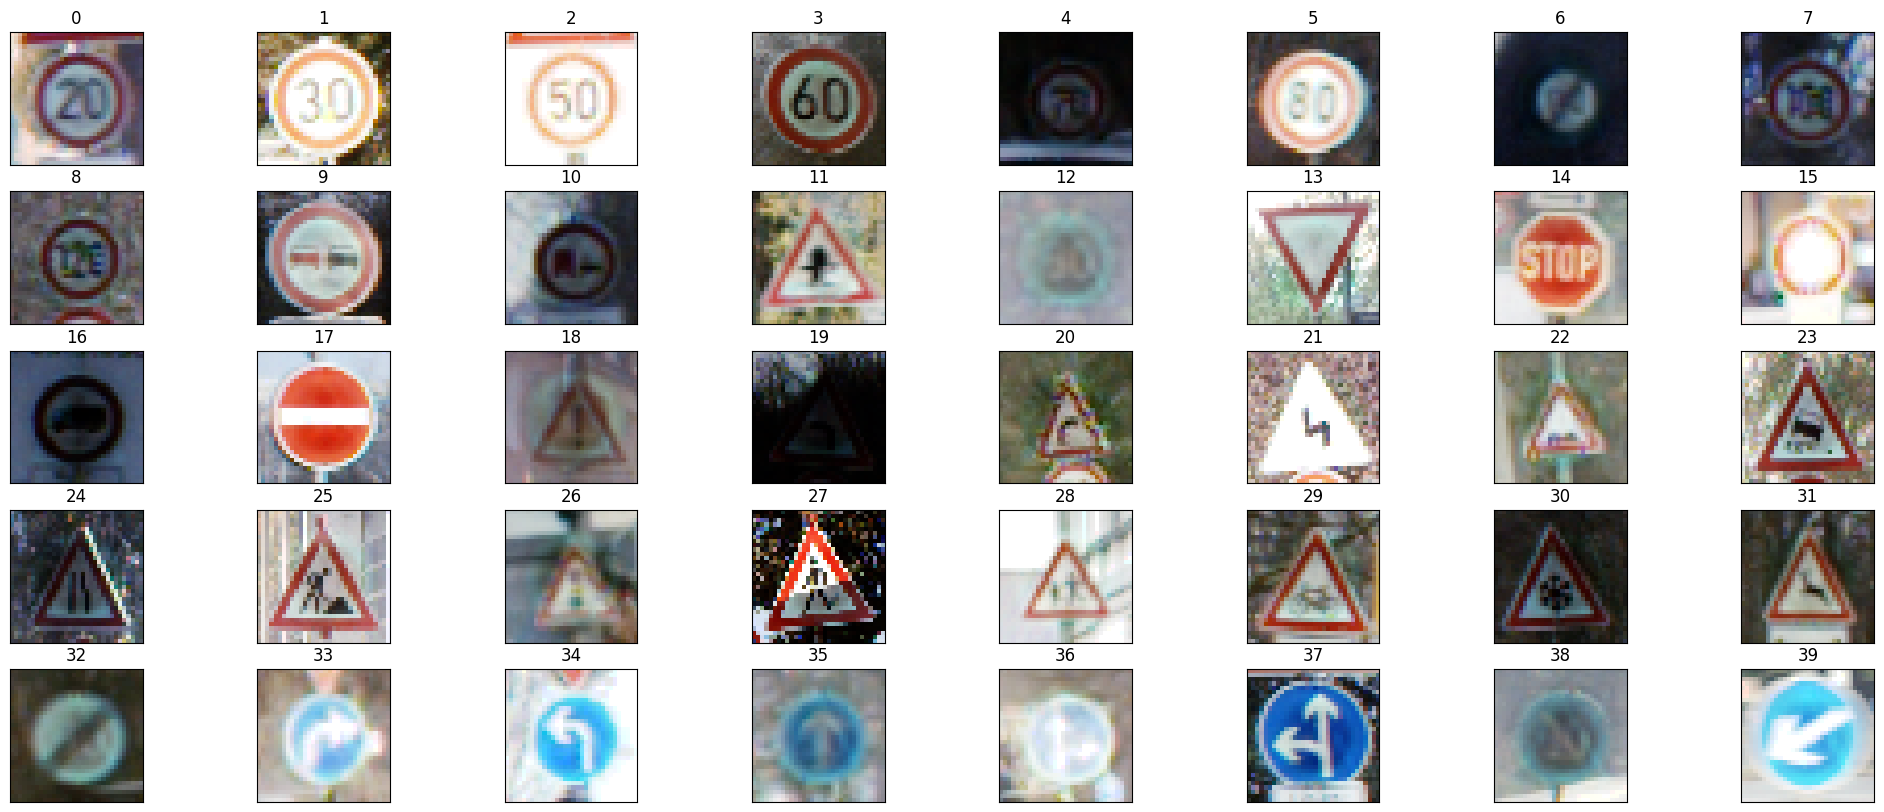

In [24]:
fig, ax_array = plt.subplots(5, 8, figsize=(25, 10))
for i, ax in enumerate(ax_array.flatten()):
    class_id = i
    X_test_in_class = X_test_norm[y_test==class_id]
    ax.imshow(X_test_in_class[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.set_title(class_id)
fig.savefig("./docs/traffic_sign_test_processed.jpg", dpi=fig.dpi)
plt.show()


In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/Model


2023-11-13 22:08:25.429206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9625 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-13 22:08:25.430191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9610 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Test Accuracy = 0.846


## Step 3: Test a Model on New Images

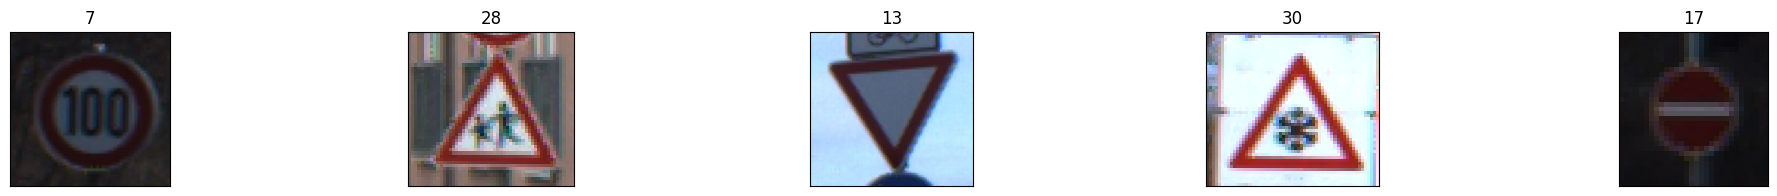

In [87]:
import matplotlib.pyplot as plt
fig, ax_array = plt.subplots(1, 5, figsize=(25, 2))
labels = [7, 28, 13, 30, 17]
for i, ax in enumerate(ax_array.flatten()):
    img = plt.imread(f"./test_signs/{i}.png")
    ax.imshow(img)
    ax.set_title(labels[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.show()

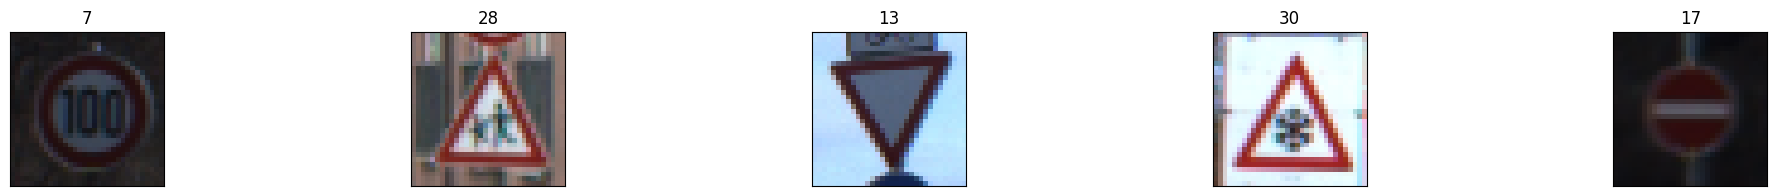

In [88]:
import cv2
import numpy as np

test_images = []
for i in range(5):
    img = plt.imread(f"./test_signs/{i}.png")
    img = cv2.resize(img, (32, 32)).clip(-1,1)
    test_images.append(img)
np_X_test = np.array(test_images)
np_y_test = np.array(labels)
np_X_test_norm = np_X_test

fig, ax_array = plt.subplots(1, 5, figsize=(25, 2))
for i, ax in enumerate(ax_array.flatten()):
    img = np_X_test_norm[i]
    ax.imshow(img)
    ax.set_title(labels[i])
    ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
plt.show()

In [119]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    probilities = np.array(sess.run(tf.nn.softmax(logits), feed_dict={x: np_X_test_norm, keep_prob: 1.}))
    predictions = np.argmax(probilities, axis=1)
    np_test_accuracy = evaluate(np_X_test_norm, np_y_test)
    print("Total Accuracy = {:.3f}".format(np_test_accuracy))


INFO:tensorflow:Restoring parameters from ./models/Model


2023-11-14 00:46:10.952955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9625 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-11-14 00:46:10.954178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9610 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


Total Accuracy = 1.000
sample 0: predicted label is 7, ground truth label is 7, top 5 probilities [9.9999988e-01 7.1578924e-08 4.3087805e-08 5.1479598e-09 1.0885214e-10]
sample 1: predicted label is 28, ground truth label is 28, top 5 probilities [9.9999928e-01 6.6589848e-07 4.6647921e-09 8.7667486e-12 4.4232656e-12]
sample 2: predicted label is 13, ground truth label is 13, top 5 probilities [1.0000000e+00 3.4404143e-15 1.0752725e-16 5.0026656e-21 2.1693791e-22]
sample 3: predicted label is 30, ground truth label is 30, top 5 probilities [1.0000000e+00 3.0281874e-10 3.8101317e-11 2.1409296e-11 2.0850877e-13]
sample 4: predicted label is 17, ground truth label is 17, top 5 probilities [9.9999952e-01 4.2119271e-07 6.9886098e-12 1.8096666e-12 1.1289301e-12]


In [138]:
with open("signnames.csv") as f:
    classes = [row.split(",")[1] for row in f][1:]

k=5
nl = "\n"
for i in range(5):
    topk_id = probilities.argsort()[:, -k:][i,:]
    topk = np.flip(probilities[i,:][topk_id])
    print(f"sample {i}: predicted label is {predictions[i]}, ground truth label is {labels[i]} {nl}")
    for j in range(5):
        print(f"   top {j} prob {topk[j]} is : {classes[topk_id[j]]}")
        
        

sample 0: predicted label is 7, ground truth label is 7 

   top 0 prob 0.9999998807907104 is : Speed limit (50km/h)

   top 1 prob 7.157892412124056e-08 is : Speed limit (70km/h)

   top 2 prob 4.308780532369383e-08 is : Speed limit (80km/h)

   top 3 prob 5.14795983619365e-09 is : Speed limit (120km/h)

   top 4 prob 1.0885214257738696e-10 is : Speed limit (100km/h)

sample 1: predicted label is 28, ground truth label is 28 

   top 0 prob 0.9999992847442627 is : Dangerous curve to the right

   top 1 prob 6.658984830210102e-07 is : Road work

   top 2 prob 4.664792108144411e-09 is : Bicycles crossing

   top 3 prob 8.766748611777064e-12 is : Beware of ice/snow

   top 4 prob 4.423265573261226e-12 is : Children crossing

sample 2: predicted label is 13, ground truth label is 13 

   top 0 prob 1.0 is : Speed limit (60km/h)

   top 1 prob 3.4404142624117626e-15 is : Speed limit (30km/h)

   top 2 prob 1.075272526162423e-16 is : Priority road

   top 3 prob 5.0026655600985355e-21 is : 